In [1]:
import os
import json 
import numpy as np
import pandas as pd
import xarray as xr

from SALib import ProblemSpec

from src.sobol_sa import wbm_sobol
from utils.global_paths import project_data_path, project_code_path

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50
plt.rcParams["font.size"] = 10

### Preliminaries

In [2]:
def store_params(param_dict, N, experiment_name):
    #########################
    # Problem spec for SAlib
    #########################
    param_names = list(param_dict.keys())
    n_params = len(param_names)

    # Check if done
    if not os.path.isfile(f"{project_data_path}/WBM/SA/{experiment_name}_params.txt"):
        sp = ProblemSpec({
            'num_vars': n_params,
            'names': param_names,
            'bounds': [param_dict[param] for param in param_names]
        }).sample_sobol(N)
    
        np.savetxt(f"{project_data_path}/WBM/SA/{experiment_name}_params.txt", sp.samples)
    else:
        print('Parameter file already exists!')

In [3]:
# Plotting function: hist
def make_hist_plot(obs, experiment, save_name):
    # Historical
    df_N1024 = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_1024_{obs}_noCC_res.csv')
    df_N2048 = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_2048_{obs}_noCC_res.csv')
    df_N4096 = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_1024_{obs}_noCC_res.csv')

    # Get params
    params = df_N1024['param'].unique()
    n_params = len(params)

    # Get metrics 
    metrics = df_N1024.metric.unique()

    ######### Plot
    fig, axs = plt.subplots(nrows=int(np.ceil(len(metrics)/3)), ncols=3,
                            figsize=(15,int(np.ceil(len(metrics)/3))*3),
                            sharey=True, sharex=False, gridspec_kw=dict(hspace=0.8))
    axs = axs.flatten()

    # Loop through all
    for ix, metric in enumerate(metrics):
        for id, data in enumerate([df_N1024, df_N2048, df_N4096]):
            axs[ix].bar(x=np.arange(id, (n_params*4) + id, 4),
                        height=data[data.metric == metric]['ST'],
                        yerr=data[data.metric == metric]['ST_conf'],
                        color=f'C{id}')

        # Tidy
        axs[ix].set_xticks(np.arange(1, (n_params*4) + 1, 4), params, rotation=90)
        axs[ix].set_title(metric)
        axs[ix].grid(alpha=0.1)

    # Legend
    custom_lines = [Line2D([0], [0], color='C0', lw=3),
                    Line2D([0], [0], color='C1', lw=3),
                    Line2D([0], [0], color='C2', lw=3)]

    axs[0].legend(custom_lines, ['N=1024', 'N=2048', 'N=4096'])

    # Title
    fig.suptitle(obs, y=0.95, fontweight='bold')

    # Remove unused axes
    unused = int(np.ceil(len(metrics)/3))*3 - len(metrics)
    if unused > 0:
        for ix in range(1,unused+1):
            axs[-ix].axis('off')

    if save_name:
        plt.savefig(f"{project_code_path}/figs/{save_name}.png", dpi=300, bbox_inches='tight')
    else:
        plt.show()

In [4]:
# Plotting function: future
def make_future_plot(obs, metric, experiment):
    # Read CC realizations
    data_all = {}
    for N in [1024, 2048, 4096]:
        for tas_delta in [-5, 1, 5, 10]:
            for prcp_factor in [0.5, 0.9, 1.1, 1.5]:
                # Output name
                read_name = f"{str(N)}_{obs}_CCtas{str(tas_delta)}prcp{str(prcp_factor)}"
                df = pd.read_csv(f"{project_data_path}/WBM/SA/{experiment}_{read_name}_res.csv")
                data_all[read_name] = df

    # Get params
    params = data_all[read_name]['param'].unique()
    n_params = len(params)

    ######### Plot
    fig, axs = plt.subplots(nrows=4, ncols=4,
                            figsize=(15,14),
                            sharey=True, sharex=False, gridspec_kw=dict(hspace=0.75))

    # Loop through all
    for ixt, tas_delta in enumerate([-5, 1, 5, 10]):
        for ixp, prcp_factor in enumerate([0.5, 0.9, 1.1, 1.5]):
            for ixn, N in enumerate([1024, 2048, 4096]):
                # Grab df
                read_name = f"{str(N)}_{obs}_CCtas{str(tas_delta)}prcp{str(prcp_factor)}"
                df = data_all[read_name]
                
                # Plot
                axs[ixt, ixp].bar(x=np.arange(ixn, (n_params*4) + ixn, 4),
                                  height=df[df.metric == metric]['ST'],
                                  yerr=df[df.metric == metric]['ST_conf'],
                                  color=f'C{ixn}')

            # Tidy
            axs[ixt, ixp].set_xticks(np.arange(1, (n_params*4) + 1, 4), params, rotation=90)
            axs[ixt, ixp].set_title(f'tas delta: {str(tas_delta)}C, prcp factor: {str(prcp_factor)}')
            axs[ixt, ixp].grid(alpha=0.1)

    # Legend
    custom_lines = [Line2D([0], [0], color='C0', lw=3),
                    Line2D([0], [0], color='C1', lw=3),
                    Line2D([0], [0], color='C2', lw=3)]

    axs[0,0].legend(custom_lines, ['N=1024', 'N=2048', 'N=4096'])

    # Title
    fig.suptitle(f"Perturbed {obs} forcing; {metric}", y=0.92, fontweight='bold')

    plt.show()

# Experiments

## Yellowstone forest

### Compute

In [5]:
experiment_name = "yellowstone"
lat, lon = 44.70597176025881, -110.40577887478884

In [6]:
# Get location coordinates
ds_grid = xr.open_dataset(f"{project_data_path}/WBM/calibration/CONUS/SMAP/SMAP_validation.nc")
lons = ds_grid.lon
lats = ds_grid.lat

# Get indices
ix = (np.abs(lons - lon)).argmin().values
print(ix)
iy = (np.abs(lats - lat)).argmin().values
print(iy)

116
157


In [7]:
# Info
ds_land = xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/CDL-NLDAS_landtypes_NLDASgrid.nc")

for var in ds_land.keys():
    print(f"{var}: {ds_land.sel(lat=lat, lon=lon, method='nearest')[var].values}")

corn: 0.0
cotton: 0.0
rice: 0.0
sorghum: 0.0
soybeans: 0.0
durum_wheat: 0.0
spring_wheat: 0.0
cropland_other: 0.0
water: 0.0
evergreen_needleleaf: 0.6766917109489441
evergreen_broadleaf: 0.0
deciduous_needleleaf: 0.0
deciduous_broadleaf: 0.0
mixed_forest: 0.0
woodland: 0.1654135286808014
wooded_grassland: 0.13533835113048553
closed_shurbland: 0.0
open_shrubland: 0.0
grassland: 0.02255639061331749
barren: 0.0
urban: 0.0


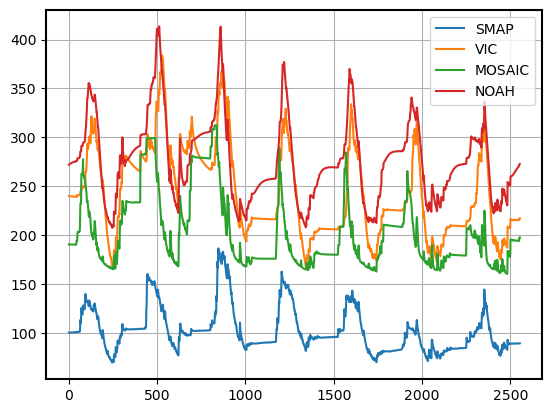

In [8]:
# Plot
fig, ax = plt.subplots()

for obs_name in ["SMAP", "VIC", "MOSAIC", "NOAH"]:
    ds_tmp = np.load(f"{project_data_path}/WBM/calibration/CONUS/{obs_name}/{obs_name}_validation.npy")
    ax.plot(ds_tmp[ix, iy, :], label=obs_name)

ax.grid()
ax.legend()
plt.show()

In [11]:
# Uncertain parameters
param_dict = {}

### Snow dynamics
param_dict['Ts'] = [-3, -1] # Snowfall threshold [C]
param_dict['Tm'] = [1, 3] # Snowmelt threshold [C]

### Soil characteristics
param_dict['wiltingp'] = [50, 300] # Wilting point [mm]
param_dict['awCap'] = [100, 400] # Available water capacity [mm/m] (mm with rootDepth of 1m)

param_dict['alpha'] = [1, 10] # affects AET []
param_dict['betaHBV'] = [1, 10] # affects runoff []

### Kc timeseries (for non-crop)
param_dict['Kmin'] = [0.1, 0.99]
param_dict['Kmax'] = [1., 2.]
param_dict['c_lai'] = [0.1, 1.]

# Store
with open(f"{project_data_path}/WBM/SA/{experiment_name}.json", 'w') as f:
    json.dump(param_dict, f)

store_params(param_dict, 1024, f"{experiment_name}_1024")
store_params(param_dict, 2048, f"{experiment_name}_2048")
store_params(param_dict, 4096, f"{experiment_name}_4096")

In [12]:
%%time
# RUN IT

# Historical
for obs_name in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        # Output name
        save_name = f"{experiment_name}_{str(N)}_{obs_name}_noCC"
        # Check if done
        if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res.csv"):
            print(f"{save_name} already done")
        else:
            # Run it
            wbm_sobol(ix=ix, iy=iy,
                      forcing=obs_name, eval=obs_name,
                      tas_delta=0., prcp_factor=1.,
                      experiment_name=experiment_name,
                      Kpet_name = "gen",
                      N=N,
                      save_name=save_name)
            print(save_name)

yellowstone_1024_SMAP_noCC
yellowstone_2048_SMAP_noCC
yellowstone_4096_SMAP_noCC
yellowstone_1024_NLDAS_noCC
yellowstone_2048_NLDAS_noCC
yellowstone_4096_NLDAS_noCC
CPU times: user 5min 39s, sys: 23 s, total: 6min 2s
Wall time: 6min 13s


### Plots

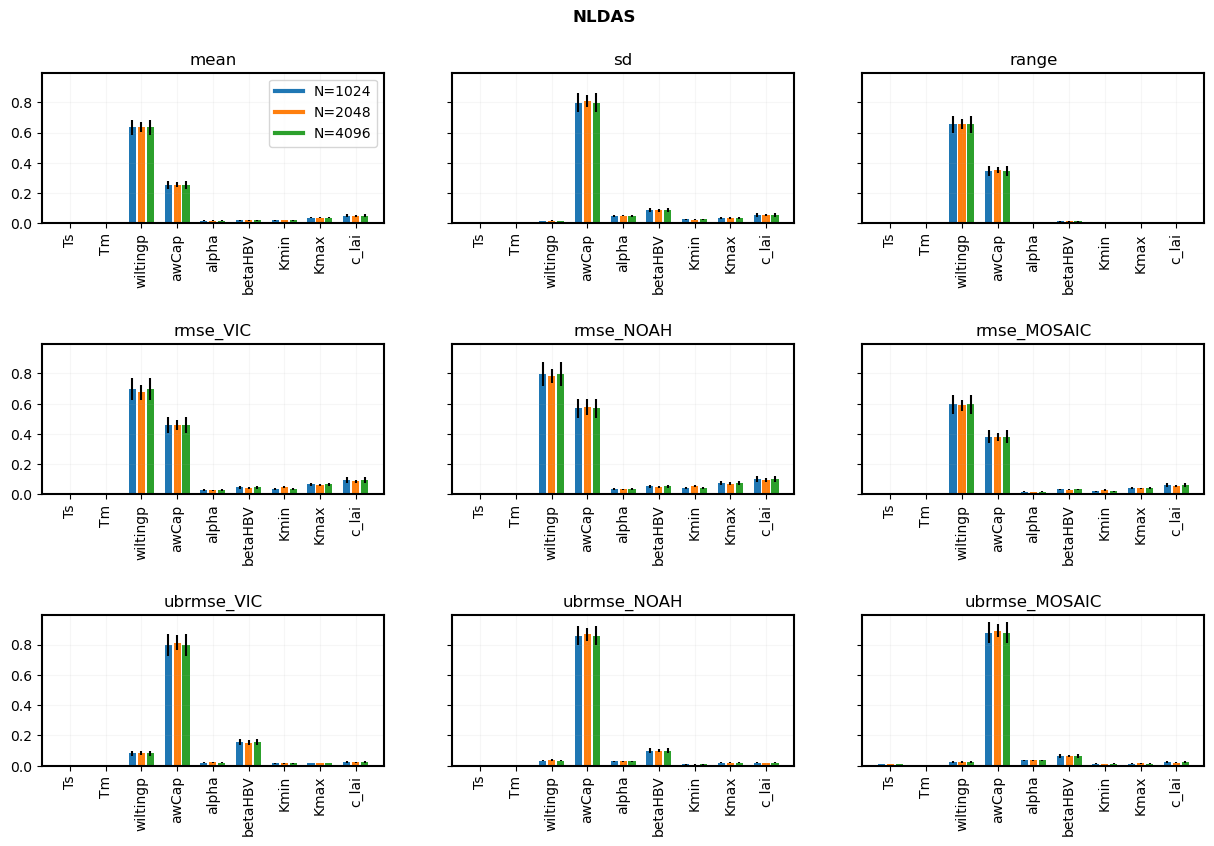

In [23]:
obs_name = "NLDAS"
experiment = "yellowstone"
save_name = f"{experiment}_{obs_name}_hist"

make_hist_plot(obs_name, experiment, save_name)

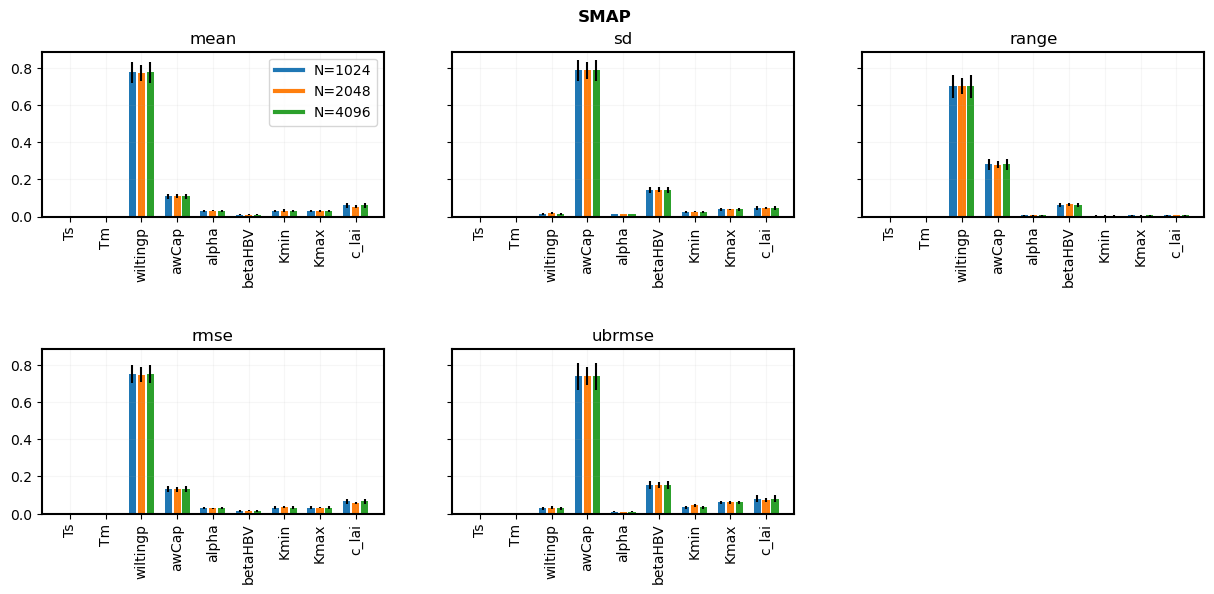

In [24]:
obs_name = "SMAP"
experiment = "yellowstone"
save_name = f"{experiment}_{obs_name}_hist"

make_hist_plot(obs_name, experiment, save_name)

## Champaign maize

### Compute

In [13]:
experiment_name = "champaign_IL_maize"
lat, lon = 40.07048942363884, -88.34859438003343

In [14]:
# Get location coordinates
ds_grid = xr.open_dataset(f"{project_data_path}/WBM/calibration/CONUS/SMAP/SMAP_validation.nc")
lons = ds_grid.lon
lats = ds_grid.lat

# Get indices
ix = (np.abs(lons - lon)).argmin().values
print(ix)
iy = (np.abs(lats - lat)).argmin().values
print(iy)

293
120


In [15]:
# Info
ds_land = xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/CDL-NLDAS_landtypes_NLDASgrid.nc")

for var in ds_land.keys():
    print(f"{var}: {ds_land.sel(lat=lat, lon=lon, method='nearest')[var].values}")

corn: 0.29478390732726606
cotton: 0.0
rice: 0.0
sorghum: 8.466422750510254e-07
soybeans: 0.27261119278595475
durum_wheat: 0.0
spring_wheat: 2.539926825153077e-06
cropland_other: 0.3042231220518098
water: 0.0
evergreen_needleleaf: 0.0
evergreen_broadleaf: 0.0
deciduous_needleleaf: 0.0
deciduous_broadleaf: 0.0
mixed_forest: 0.0
woodland: 0.0
wooded_grassland: 0.03378378227353096
closed_shurbland: 0.0
open_shrubland: 0.0
grassland: 0.0
barren: 0.0
urban: 0.09459459781646729


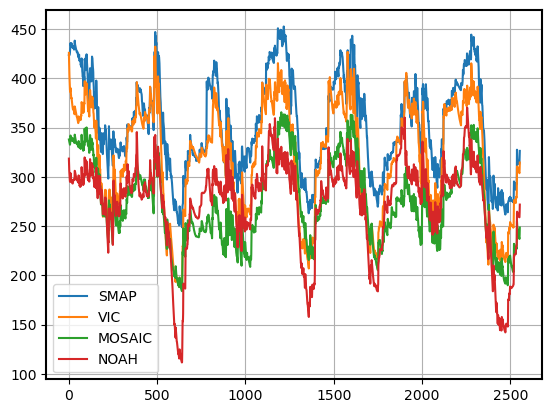

In [16]:
# Plot
fig, ax = plt.subplots()

for obs_name in ["SMAP", "VIC", "MOSAIC", "NOAH"]:
    ds_tmp = np.load(f"{project_data_path}/WBM/calibration/CONUS/{obs_name}/{obs_name}_validation.npy")
    ax.plot(ds_tmp[ix, iy, :], label=obs_name)

ax.grid()
ax.legend()
plt.show()

In [17]:
# Uncertain parameters
param_dict = {}

### Snow dynamics
param_dict['Ts'] = [-3, -1] # Snowfall threshold [C]
param_dict['Tm'] = [1, 3] # Snowmelt threshold [C]

### Soil characteristics
# NOAH wiltingp: ~90mm, MOSAIC: ~170
param_dict['wiltingp'] = [50, 400] # Wilting point [mm]
# UC Davis awCap: ~250mm
param_dict['awCap'] = [100, 400] # Available water capacity [mm/m] (mm with rootDepth of 1m)

param_dict['alpha'] = [1, 10] # affects AET []
param_dict['betaHBV'] = [1, 10] # affects runoff []

### Kc timeseries (for maize)
param_dict['GS_start'] = [60, 152] 
param_dict['GS_end'] = [244, 334] 
param_dict['L_ini'] = [0.07, 0.22] 
param_dict['L_dev'] = [0.18, 0.33] 
param_dict['L_mid'] = [0.13, 0.38] 
param_dict['Kc_ini'] = [0.1, 0.5] 
param_dict['Kc_mid'] = [1., 1.5] 
param_dict['Kc_end'] = [0.2, 0.6] 
param_dict['Kmin'] = param_dict['Kc_ini']
param_dict['Kmax'] = param_dict['Kc_mid']
param_dict['c_lai'] = [0.1, 1]

# Store
with open(f"{project_data_path}/WBM/SA/{experiment_name}.json", 'w') as f:
    json.dump(param_dict, f)

store_params(param_dict, 1024, f"{experiment_name}_1024")
store_params(param_dict, 2048, f"{experiment_name}_2048")
store_params(param_dict, 4096, f"{experiment_name}_4096")

In [18]:
%%time
# Historical
for obs in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        # Output name
        save_name = f"{experiment_name}_{str(N)}_{obs}_noCC"
        # Check if done
        if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res.csv"):
            print(f"{save_name} already done")
        else:
            # Run it
            wbm_sobol(ix=ix, iy=iy,
                      forcing=obs, eval=obs,
                      tas_delta=0., prcp_factor=1.,
                      experiment_name=experiment_name,
                      Kpet_name = "crop",
                      N=N,
            save_name=save_name)
            print(save_name)

champaign_IL_maize_1024_SMAP_noCC
champaign_IL_maize_2048_SMAP_noCC
champaign_IL_maize_4096_SMAP_noCC
champaign_IL_maize_1024_NLDAS_noCC
champaign_IL_maize_2048_NLDAS_noCC
champaign_IL_maize_4096_NLDAS_noCC
CPU times: user 10min 45s, sys: 11.1 s, total: 10min 56s
Wall time: 11min 1s


In [ ]:
%%time
# "Future"
for obs in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        for tas_delta in [-5, 1, 5, 10]:
            for prcp_factor in [0.5, 0.9, 1.1, 1.5]:
                # Output name
                save_name = f"{experiment_name}_{str(N)}_{obs}_CCtas{str(tas_delta)}prcp{str(prcp_factor)}"
                # Check if done
                if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res.csv"):
                    print(f"{save_name} already done")
                else:
                    # Run it
                    wbm_sa(ix=ix, iy=iy,
                           forcing=obs, eval=None,
                           tas_delta=tas_delta, prcp_factor=prcp_factor,
                           experiment_name=experiment_name,
                           N=N,
                           save_name=save_name)
                    print(save_name)

### Plots

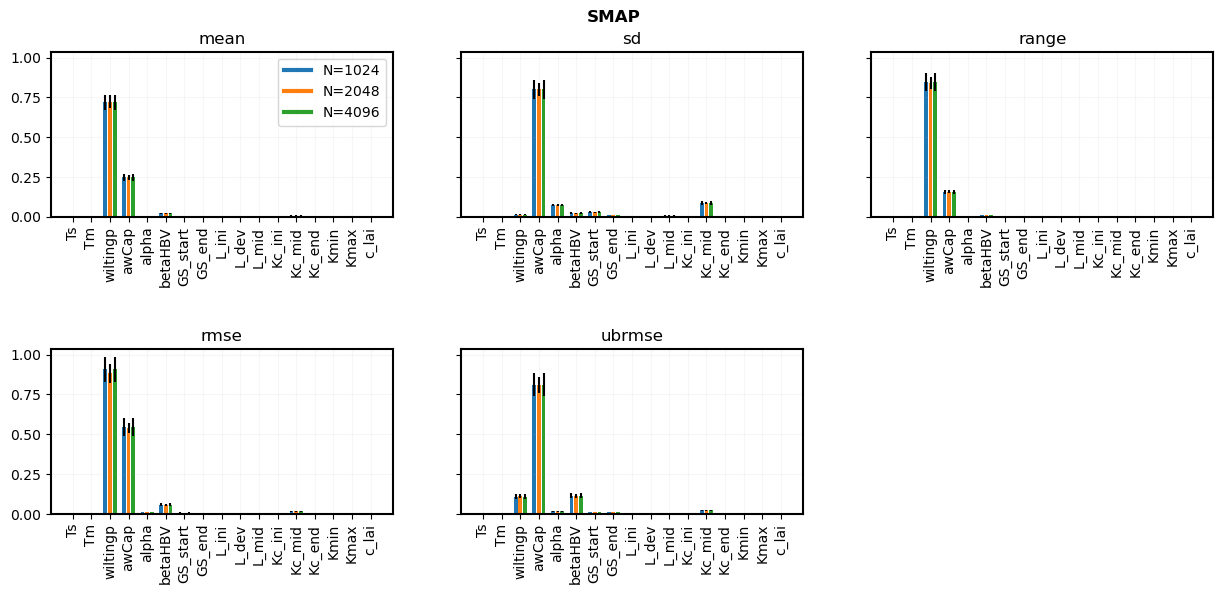

In [20]:
obs_name = "SMAP"
experiment = "champaign_IL_maize"
save_name = f"{experiment}_{obs_name}_hist"

make_hist_plot(obs_name, experiment, save_name)

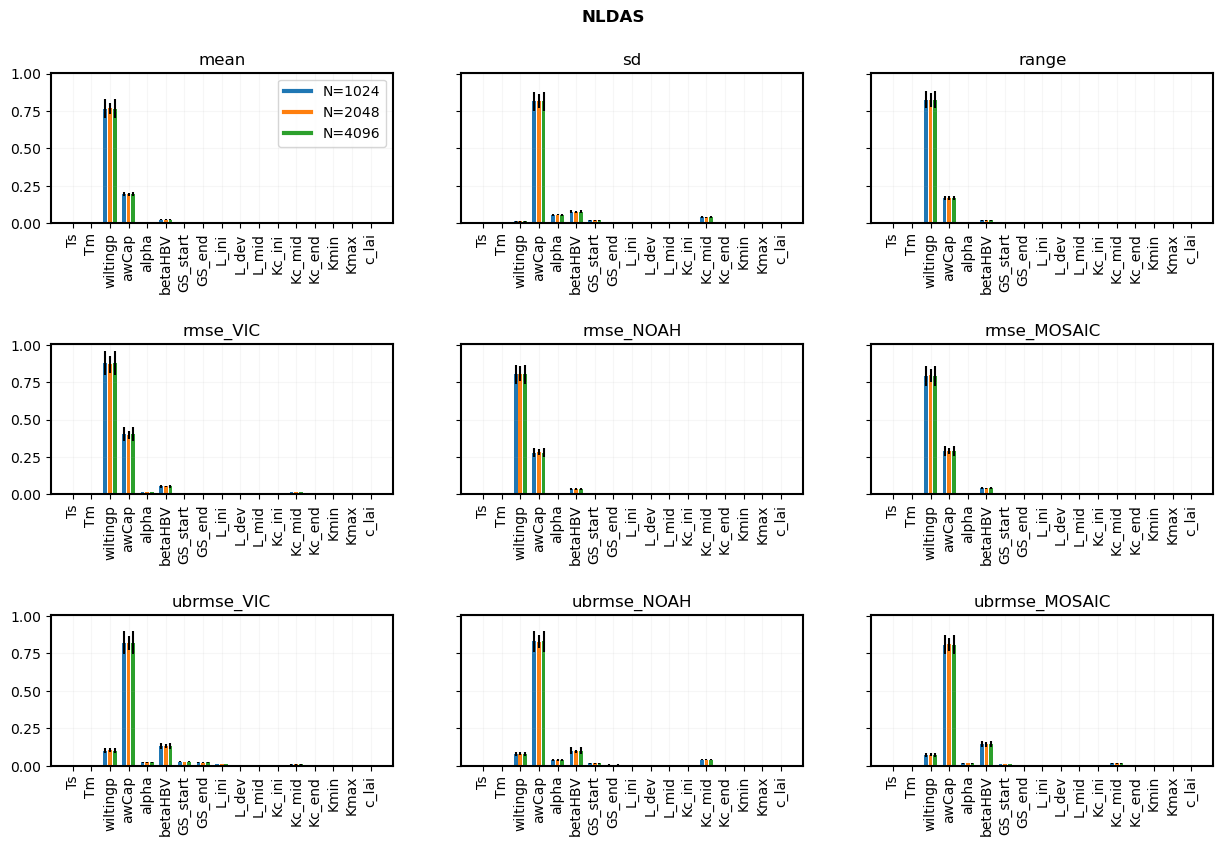

In [21]:
obs_name = "NLDAS"
experiment = "champaign_IL_maize"
save_name = f"{experiment}_{obs_name}_hist"

make_hist_plot(obs_name, experiment, save_name)

In [23]:
# obs = "SMAP"
# experiment = "champaign_IL_maize"
# metric = "mean"

# make_future_plot(obs, metric, experiment)

In [24]:
# obs = "SMAP"
# experiment = "champaign_IL_maize"
# metric = "sd"

# make_future_plot(obs, metric, experiment)

In [25]:
# obs = "SMAP"
# experiment = "champaign_IL_maize"
# metric = "range"

# make_future_plot(obs, metric, experiment)

In [26]:
# obs = "NLDAS"
# experiment = "champaign_IL_maize"
# metric = "mean"

# make_future_plot(obs, metric, experiment)

In [27]:
# obs = "NLDAS"
# experiment = "champaign_IL_maize"
# metric = "sd"

# make_future_plot(obs, metric, experiment)

In [28]:
# obs = "NLDAS"
# experiment = "champaign_IL_maize"
# metric = "range"

# make_future_plot(obs, metric, experiment)